## Import libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    DotProduct,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

## Read in data

In [30]:
# Read data
train = pd.read_csv('./processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,
2022-01-24 00:00:00,135.0,304.43,16272,1199.63,1838.21,1.85,115,0,2022-01-24 00:00:00,False,0,0,1
2022-01-24 06:00:00,1260.0,1815.15,165343,9646.30,14880.64,1.96,1019,0,2022-01-24 06:00:00,False,0,6,2
2022-01-24 12:00:00,931.0,1768.98,113994,8246.48,12426.19,2.00,718,0,2022-01-24 12:00:00,False,0,12,3
2022-01-24 18:00:00,1303.0,2454.15,155781,10295.40,16299.44,2.26,958,0,2022-01-24 18:00:00,False,0,18,4
2022-01-25 00:00:00,173.0,430.92,21140,1561.87,2394.96,2.00,135,0,2022-01-25 00:00:00,False,1,0,5


In [31]:
# Read data
test = pd.read_csv('./processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,
2024-01-22 00:00:00,137.0,269.00,19576,1475.61,2372.65,2.00,130,0,2024-01-22 00:00:00,False,0,0,1
2024-01-22 06:00:00,1281.0,1905.20,178656,15152.25,22324.27,2.66,1054,0,2024-01-22 06:00:00,False,0,6,2
2024-01-22 12:00:00,1170.0,1998.20,158137,14191.89,21761.89,3.08,951,0,2024-01-22 12:00:00,False,0,12,3
2024-01-22 18:00:00,1019.0,2013.76,134764,12625.03,20186.25,3.14,839,0,2024-01-22 18:00:00,False,0,18,4
2024-01-23 00:00:00,470.0,1000.13,56654,5486.23,8449.09,3.00,353,0,2024-01-23 00:00:00,False,1,0,5


In [32]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 904 entries, 2022-01-24 00:00:00 to 2023-05-15 18:00:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  904 non-null    float64
 1   trip_distance    904 non-null    float64
 2   DOLocationID     904 non-null    int64  
 3   fare_amount      904 non-null    float64
 4   total_amount     904 non-null    float64
 5   tip_amount       904 non-null    float64
 6   pickup_count     904 non-null    int64  
 7   is_holiday       904 non-null    int64  
 8   pickup_time      904 non-null    object 
 9   weekend          904 non-null    bool   
 10  weekday          904 non-null    int64  
 11  hour             904 non-null    int32  
 12  time_index       904 non-null    int64  
dtypes: bool(1), float64(5), int32(1), int64(5), object(1)
memory usage: 89.2+ KB


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2024-01-22 00:00:00 to 2024-05-13 18:00:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  452 non-null    float64
 1   trip_distance    452 non-null    float64
 2   DOLocationID     452 non-null    int64  
 3   fare_amount      452 non-null    float64
 4   total_amount     452 non-null    float64
 5   tip_amount       452 non-null    float64
 6   pickup_count     452 non-null    int64  
 7   is_holiday       452 non-null    int64  
 8   pickup_time      452 non-null    object 
 9   weekend          452 non-null    bool   
 10  weekday          452 non-null    int64  
 11  hour             452 non-null    int32  
 12  time_index       452 non-null    int64  
dtypes: bool(1), float64(5), int32(1), int64(5), object(1)
memory usage: 44.6+ KB


In [34]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

In [35]:
train.groupby('hour')['pickup_count'].mean()

hour
0      232.920354
6     1117.628319
12    1195.699115
18    1081.000000
Name: pickup_count, dtype: float64

In [36]:
test.groupby('hour')['pickup_count'].mean()

hour
0      247.017699
6     1051.513274
12    1195.017699
18    1138.309735
Name: pickup_count, dtype: float64

## Plot general Time Series

## Over chosen time interval

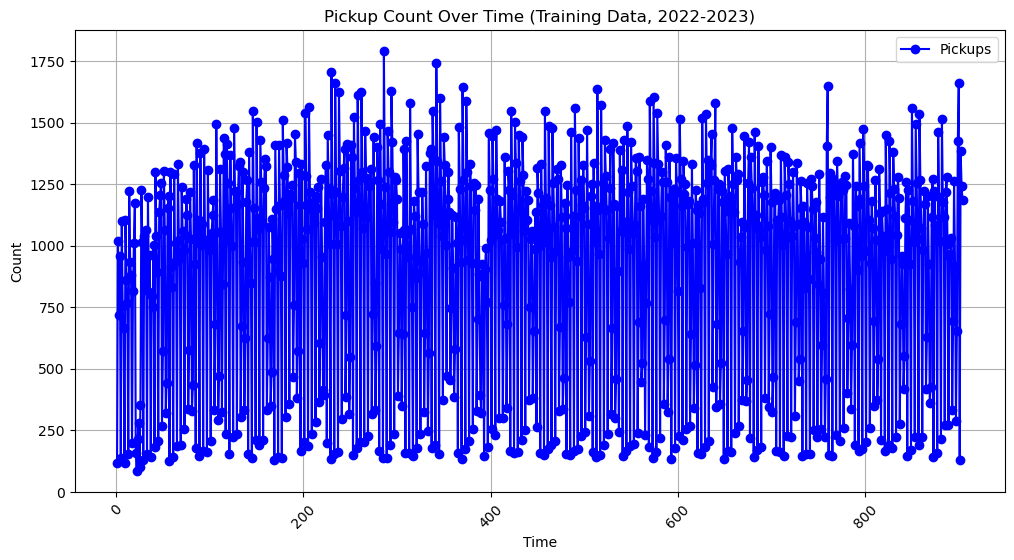

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2022-2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

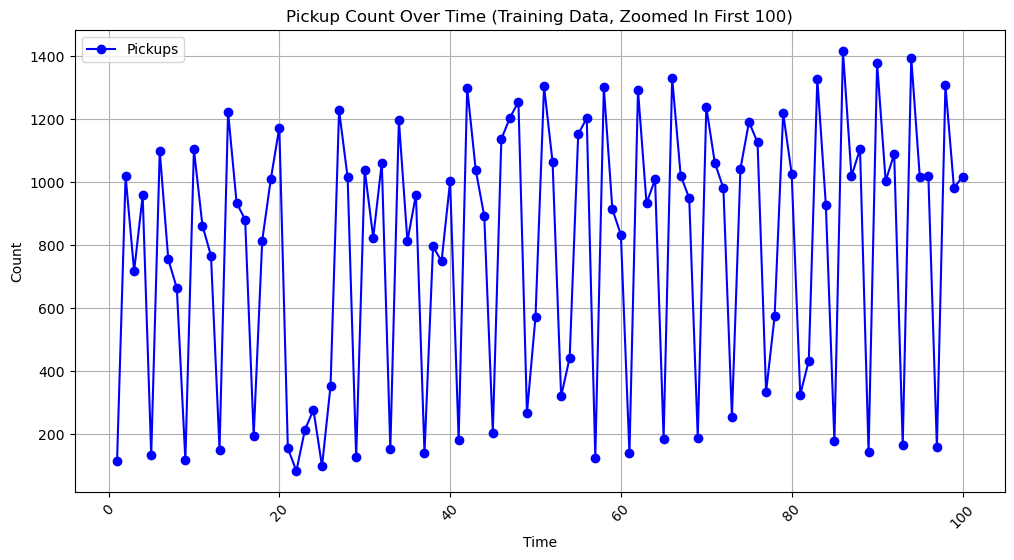

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, Zoomed In First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

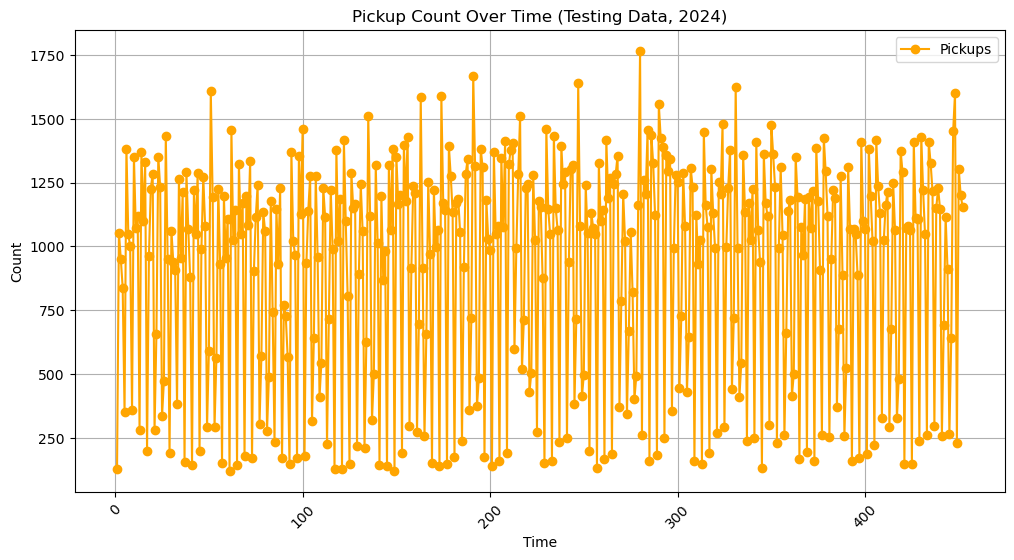

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

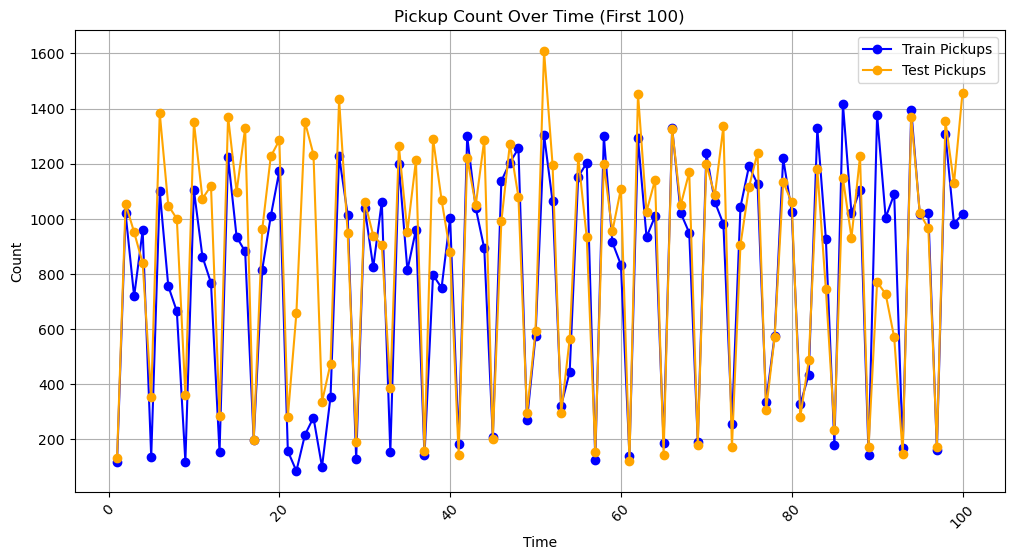

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Train Pickups', color='blue')
plt.plot(test['time_index'][:100], test['pickup_count'][:100], marker='o', label='Test Pickups', color='orange')
plt.title('Pickup Count Over Time (First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Over the hour

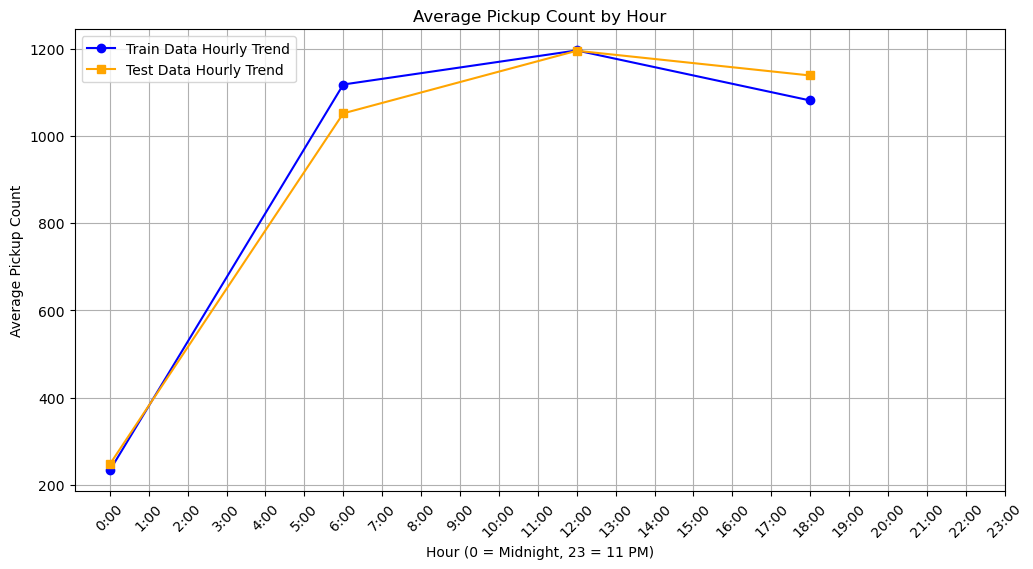

In [41]:
# Group by hour and calculate the mean pickup count for each hour
hourly_trend_train = train.groupby('hour')['pickup_count'].mean()
hourly_trend_test = test.groupby('hour')['pickup_count'].mean()

# Plot hourly trend
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_trend_train.index,
    hourly_trend_train.values,
    marker='o',
    label='Train Data Hourly Trend',
    color='blue'
)
plt.plot(
    hourly_trend_test.index,
    hourly_trend_test.values,
    marker='s',
    label='Test Data Hourly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Hour')
plt.xlabel('Hour (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(0, 24),
    labels=[f'{h}:00' for h in range(0, 24)],  # Formats hour labels as '0:00', '1:00', etc.
    rotation=45
)
plt.grid()
plt.legend()
plt.show()

## Over each weekday

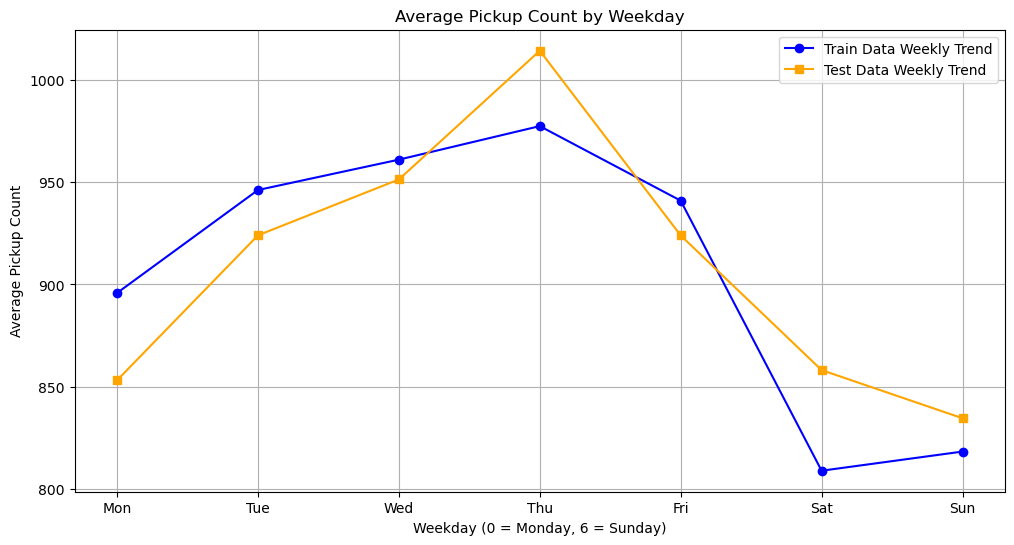

In [42]:
# Group by weekday and calculate the mean pickup count for each weekday
weekly_trend_train = train.groupby('weekday')['pickup_count'].mean()
weekly_trend_test = test.groupby('weekday')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=weekly_trend_train.index,
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.grid()
plt.legend()
plt.show()


## Over the weeks

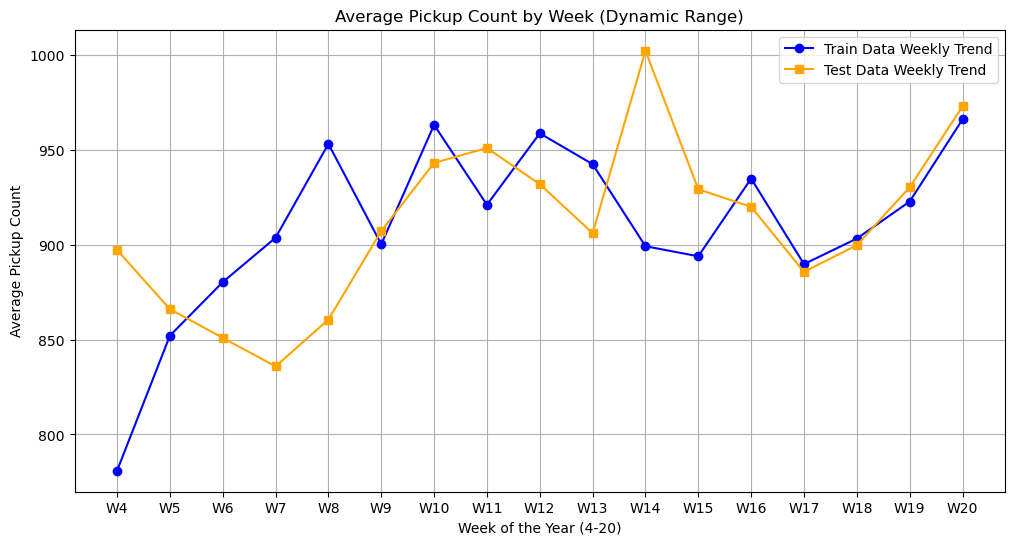

In [43]:
# Group by week of the year and calculate the mean pickup count for each week
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
test['pickup_time'] = pd.to_datetime(test['pickup_time'])
train['week'] = train['pickup_time'].dt.isocalendar().week
test['week'] = test['pickup_time'].dt.isocalendar().week

# Determine the min and max week from both datasets
min_week = min(train['week'].min(), test['week'].min())
max_week = max(train['week'].max(), test['week'].max())

# Group by week for the range of weeks in the data
weekly_trend_train = train.groupby('week')['pickup_count'].mean()
weekly_trend_test = test.groupby('week')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Week (Dynamic Range)')
plt.xlabel(f'Week of the Year ({min_week}-{max_week})')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(min_week, max_week + 1, max(1, (max_week - min_week) // 10)),  # Adjust ticks dynamically
    labels=[f'W{k}' for k in range(min_week, max_week + 1, max(1, (max_week - min_week) // 10))]
)
plt.grid()
plt.legend()
plt.show()


## Over the month

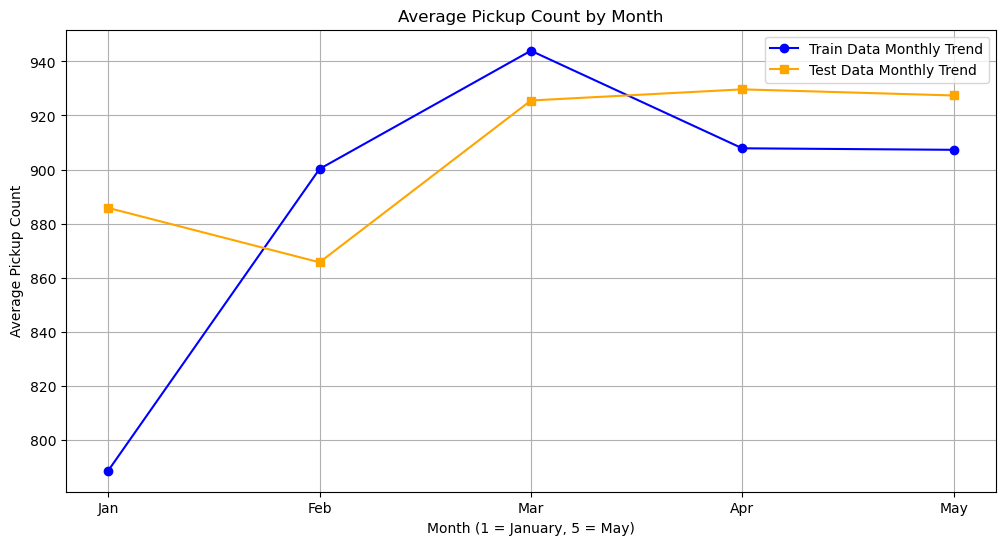

In [44]:
# Group by month and calculate the mean pickup count for each month
monthly_trend_train = train.groupby(train['pickup_time'].dt.month)['pickup_count'].mean()
monthly_trend_test = test.groupby(test['pickup_time'].dt.month)['pickup_count'].mean()

# Plot monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_trend_train.index,
    monthly_trend_train.values,
    marker='o',
    label='Train Data Monthly Trend',
    color='blue'
)
plt.plot(
    monthly_trend_test.index,
    monthly_trend_test.values,
    marker='s',
    label='Test Data Monthly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Month')
plt.xlabel('Month (1 = January, 5 = May)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(1, 6),
    labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May'
    ]
)
plt.grid()
plt.legend()
plt.show()


## Model Fitting

## All vars

In [45]:
# Features (X) - Including the new feature
X_train = train[['hour', 'weekday']].values
X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].values
y_test = test['pickup_count'].values

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [46]:
X_train

array([[-1.34164079, -1.47869908],
       [-0.4472136 , -1.47869908],
       [ 0.4472136 , -1.47869908],
       ...,
       [-0.4472136 , -1.47869908],
       [ 0.4472136 , -1.47869908],
       [ 1.34164079, -1.47869908]])

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((904, 2), (904,), (452, 2), (452,))

In [20]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
   C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
   * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))  # Squared exponential

#    + C(50.0, (1e-1, 1e5))  # Constant term for cosine scaling
#    * ExpSineSquared(length_scale=1.0, periodicity=12, length_scale_bounds=(1e-2, 1e2))  # Cosine
## These two above work

#    + C(50.0, (1e-1, 1e5))
#    * ExpSineSquared(length_scale=1.0, periodicity=84, length_scale_bounds=(1e-2, 1e2)) # Weekly component

  + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 0.901**2 * RBF(length_scale=0.703) + WhiteKernel(noise_level=0.082)


Root Mean Squared Error: 136.116
MAPE: 0.125


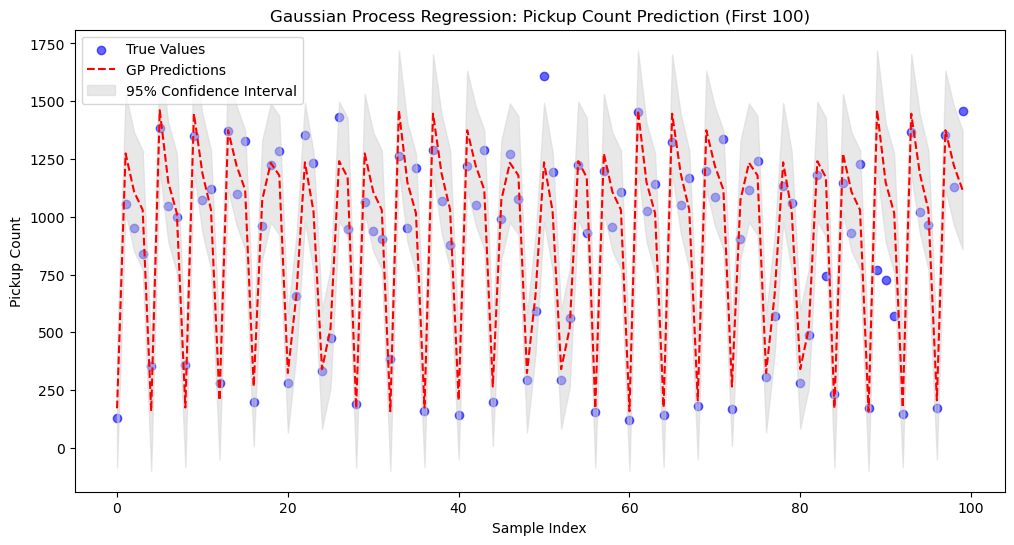

Sigma
131.22162686470125


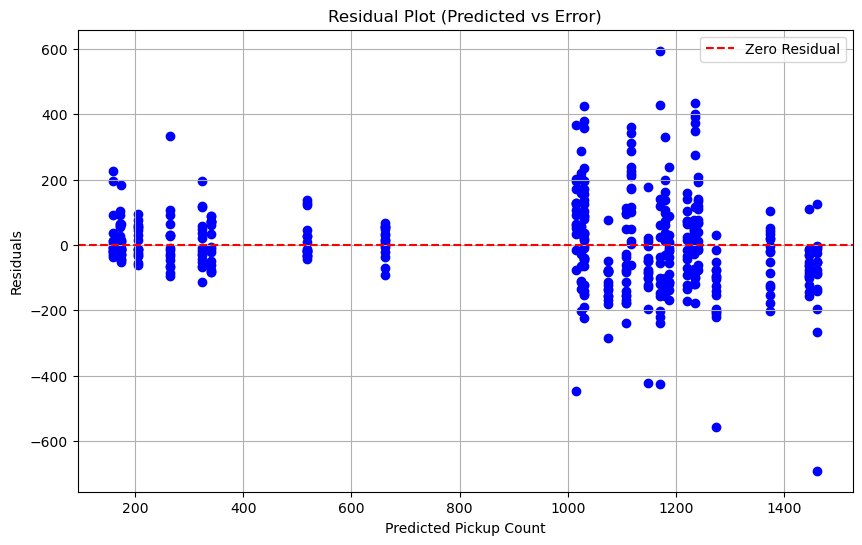

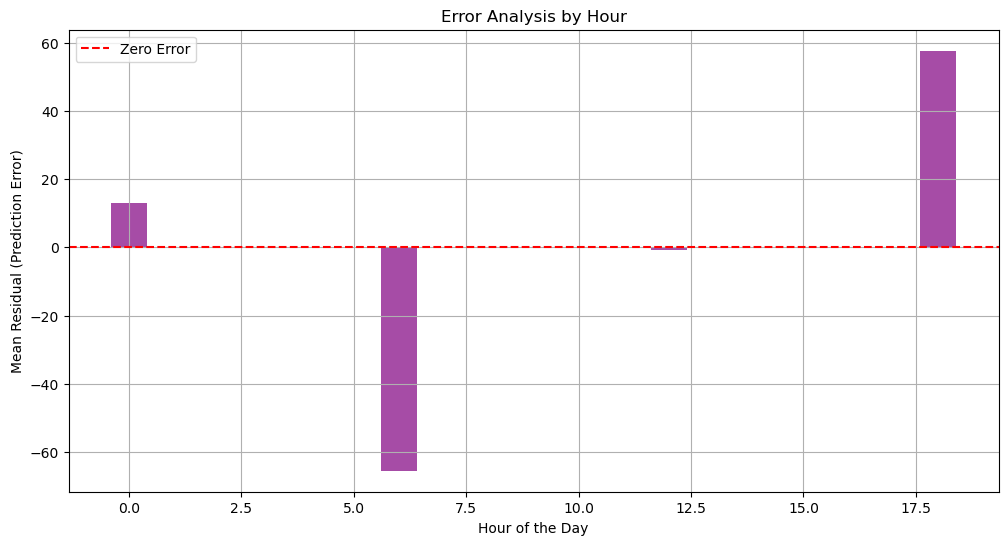

In [21]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
#   C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
#   * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))  # Squared exponential

    C(50.0, (1e-5, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=2, periodicity_bounds="fixed")  # Cosine shift
## These two above work

#    + C(50.0, (1e-1, 1e5))
#    * ExpSineSquared(length_scale=1.0, periodicity=84, length_scale_bounds=(1e-2, 1e2)) # Weekly component

   + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 0.959**2 * ExpSineSquared(length_scale=0.03, periodicity=2) + WhiteKernel(noise_level=0.0818)


Root Mean Squared Error: 136.996
MAPE: 0.126


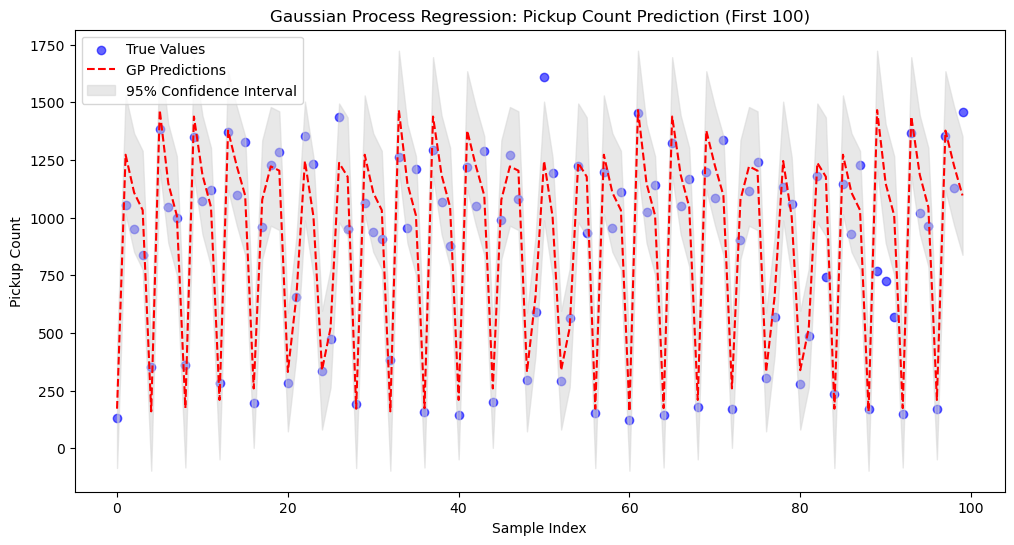

Sigma
131.24737935705147


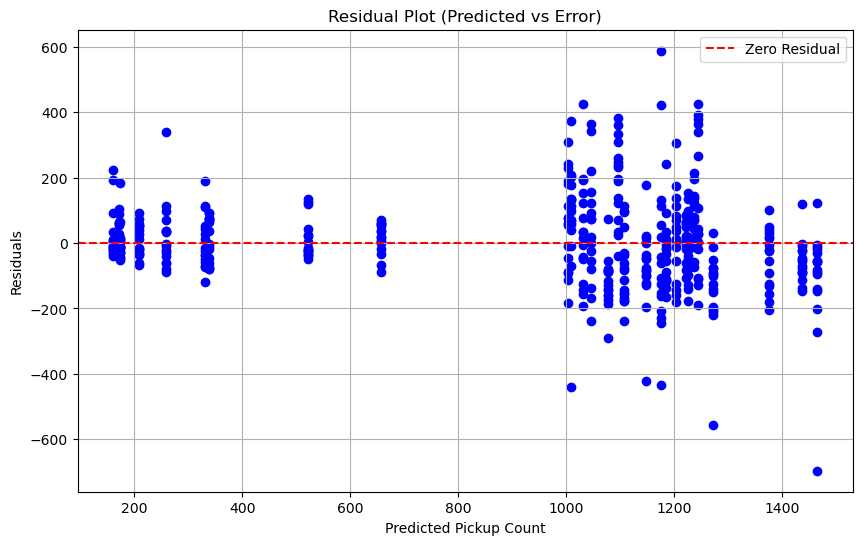

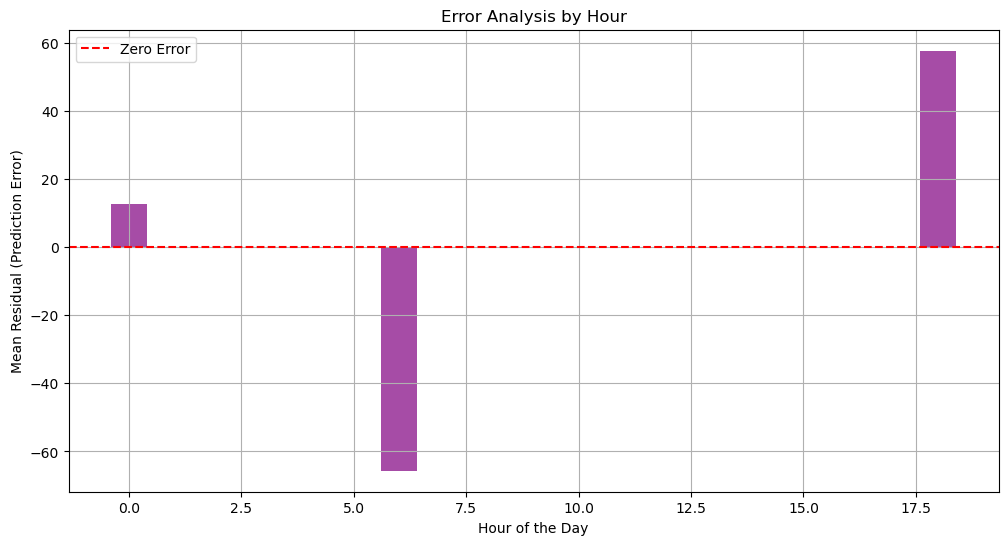

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
  # C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
  # * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))  # Squared exponential

    C(50.0, (1e-5, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=4, periodicity_bounds="fixed")  # Cosine daily
## These two above work

#    + C(50.0, (1e-1, 1e5))
#    * ExpSineSquared(length_scale=1.0, periodicity=84, length_scale_bounds=(1e-2, 1e2)) # Weekly component

  + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 0.958**2 * ExpSineSquared(length_scale=7.22e-05, periodicity=4) + WhiteKernel(noise_level=0.0818)


Root Mean Squared Error: 137.053
MAPE: 0.126


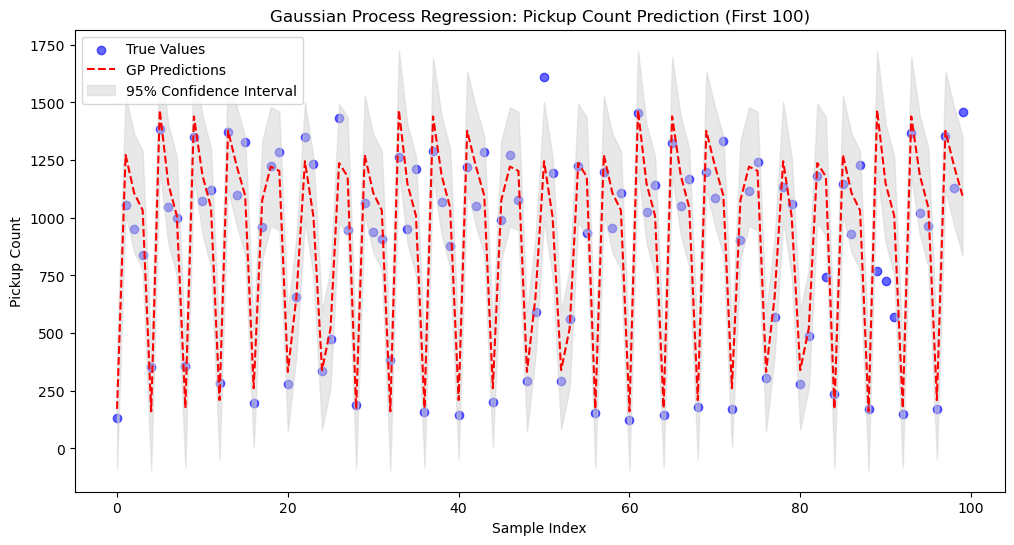

Sigma
131.24961143338484


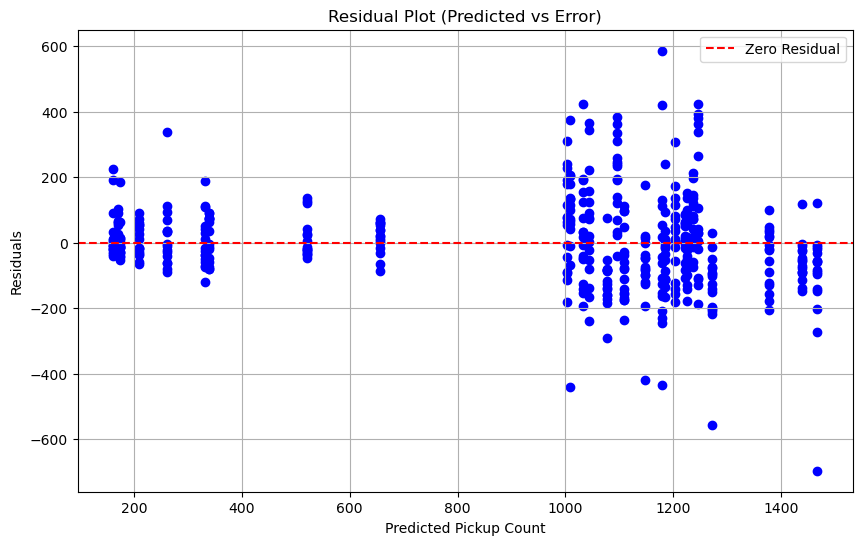

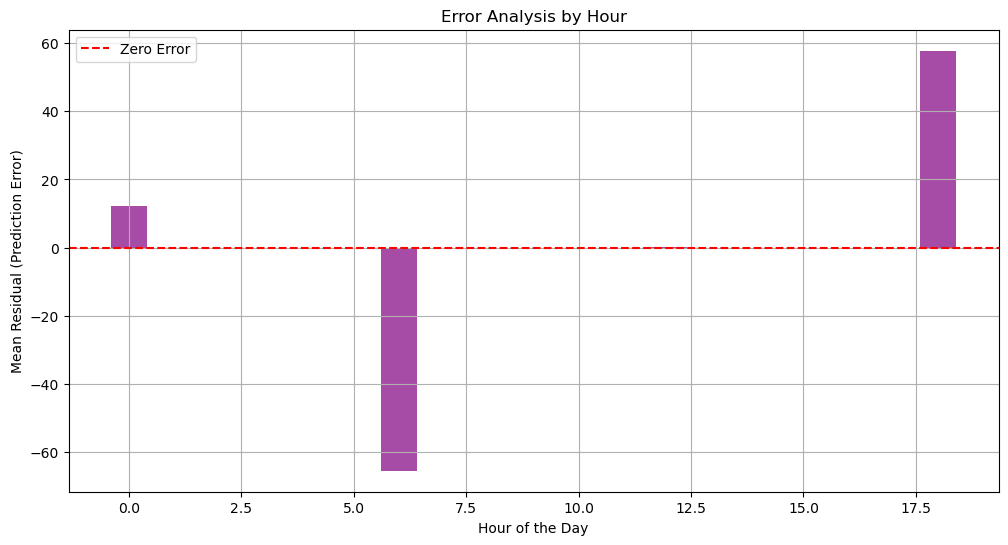

In [25]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
#   C(30.0, (1e-1, 1e5))  # Constant term to scale the entire kernel
#   * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))  # Squared exponential

     C(50.0, (1e-5, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=2, periodicity_bounds="fixed")  # Cosine daily
## These two above work

    + C(50.0, (1e-5, 1e5))
    * ExpSineSquared(length_scale=1.0, periodicity=4, periodicity_bounds="fixed") # Cosine shift

  + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 0.959**2 * ExpSineSquared(length_scale=0.03, periodicity=2) + 0.00316**2 * ExpSineSquared(length_scale=0.000207, periodicity=4) + WhiteKernel(noise_level=0.0818)


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Root Mean Squared Error: 136.996
MAPE: 0.126


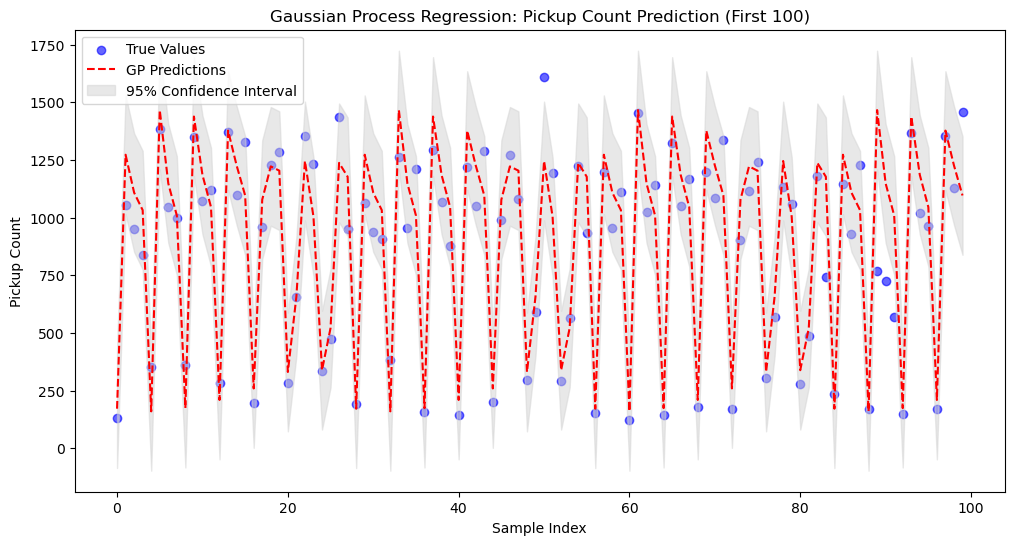

Sigma
131.24794996912783


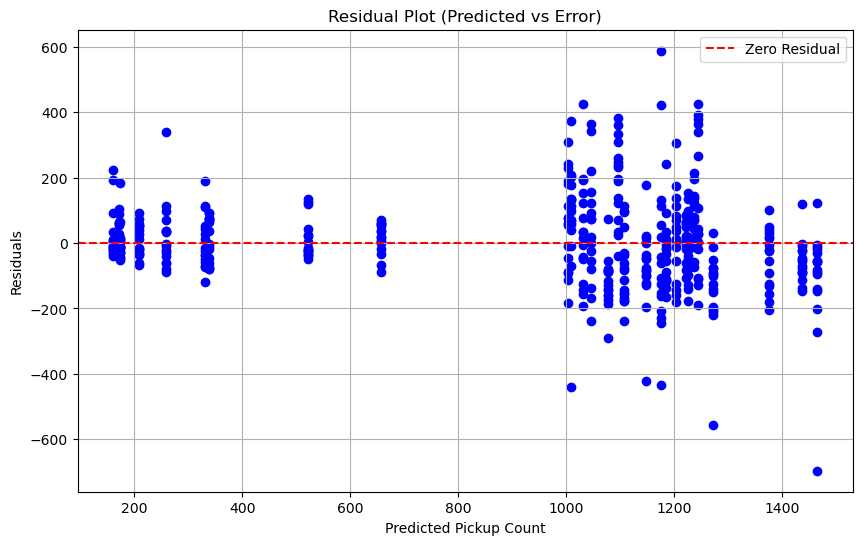

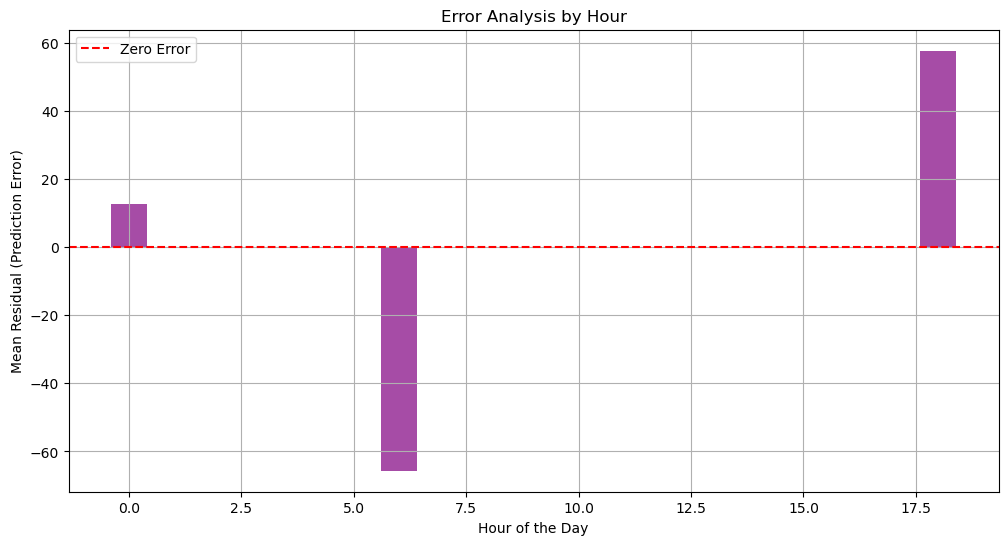

In [27]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
   C(30.0, (1e-5, 1e5))  # Constant term to scale the entire kernel
   * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))  # Squared exponential

    + C(50.0, (1e-5, 1e5))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=2, periodicity_bounds="fixed")  # Cosine
## These two above work

    + C(50.0, (1e-5, 1e5))
    * ExpSineSquared(length_scale=1.0, periodicity=4, periodicity_bounds="fixed") # Weekly component

  + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 1.15**2 * RBF(length_scale=0.957) + 0.00316**2 * ExpSineSquared(length_scale=0.0089, periodicity=2) + 0.142**2 * ExpSineSquared(length_scale=0.537, periodicity=4) + WhiteKernel(noise_level=0.0818)


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Root Mean Squared Error: 200.791
MAPE: 0.085


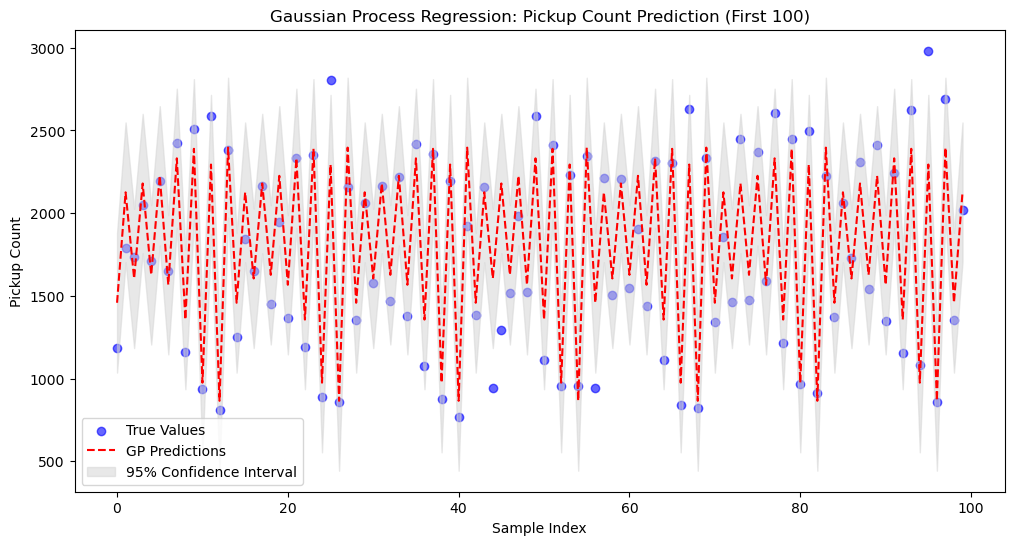

Sigma
215.07571861698574


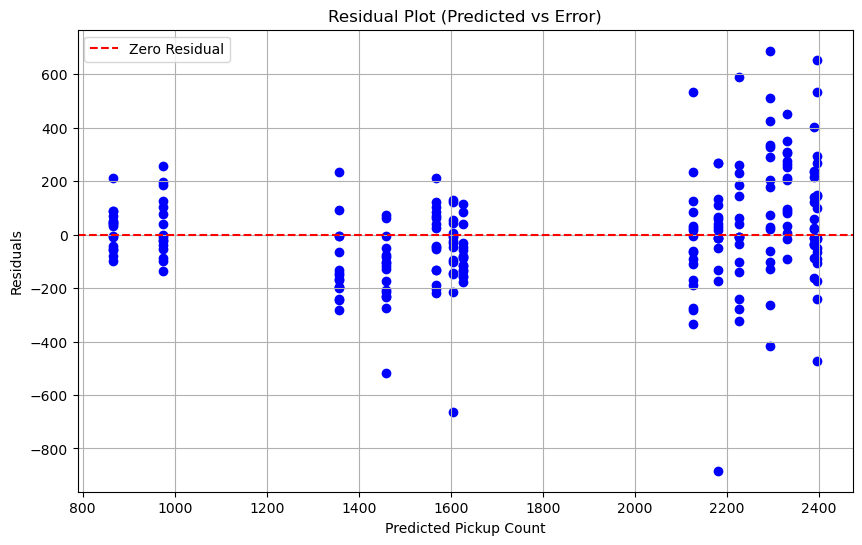

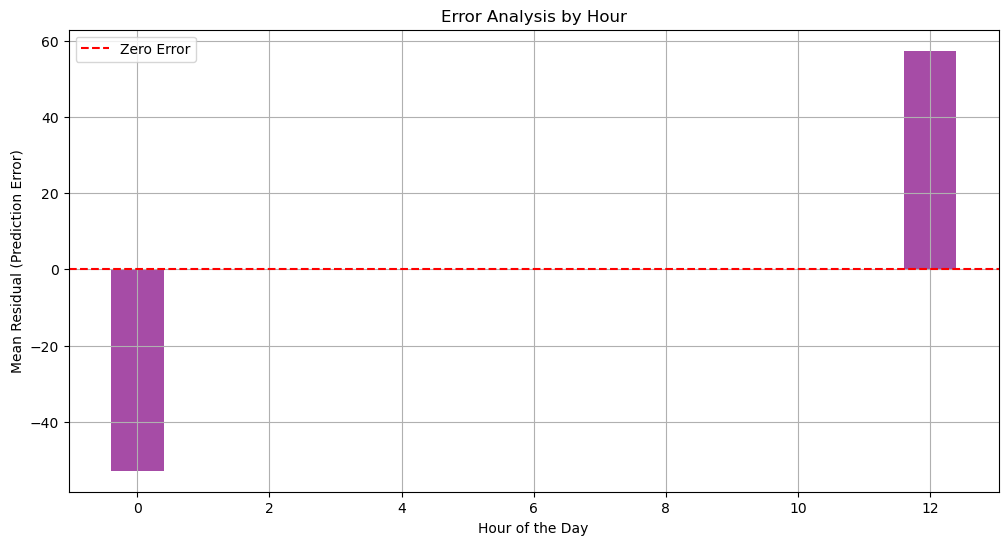

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


## Final